In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import sys
import os
from funcs import *
from simulator import *
import seaborn as sns

In [2]:
def score_geral(namefile, deviation=1/2, max_time=3, old_schedule=None):
    entrada = open(f'in/{namefile}.txt', 'r')
    saida = open(f'out/{namefile}.out', 'w')

    D,I,S,V,F, sts, cars, inters = pega_input(entrada.readline)
    #import pdb; pdb.set_trace()
    schedule = sol_batata(D,I,S,V,F, sts, cars, inters, deviation=deviation, max_time=max_time, old_schedule=old_schedule)
    
    new_old_schedule = schedule.copy()
    try:
        output = form_out(schedule)[:-1]
    except:
        import pdb; pdb.set_trace()
    bkp_cars = cars.copy()
    
    total, finished_cars = score(D, F, sts, cars, inters, schedule)
    #print(f'score: {total:,}')
    return cars, bkp_cars, finished_cars, total, sts, inters, schedule, total, new_old_schedule

In [3]:
# Cada linha é um carro, cada coluna é uma estatística do carro
def data_car(cars, sts, bkp_cars):
    data = []
    cars.update(finished_cars)
    for car in cars:
        #print(cars[car])
        path = bkp_cars[car]#['path']
        qtde_ruas = len(path)# - 1
        
        total_tam_ruas = 0
        for st in path[1:]:
            dims = sts[st]['size']
            tam_rua = dims[2]
            total_tam_ruas += tam_rua
            #print(f'rua {st} : {dims}')
            
        ruas_intersec = 0
        for car2 in cars:
            path1 = set(path)      
            
            path2 = bkp_cars[car2]#['path']
            #qtde_ruas = len(path2) - 1
            path2 = set(path2)
            
            intersecs = len(path1.intersection(path2))
            ruas_intersec += intersecs
            
        sts_with_intersect = 0#{}
        for st in path:
            #st_has_intersect[st] = False 
            for car2 in cars:
                path = bkp_cars[car]#['path'] 
                if st in path:
                    #st_has_intersect[st] = True
                    sts_with_intersect += 1
                    break
        #print('sthasinter', st_has_intersect)
        score_car = cars[car]['score']
        #print(f'{car} : ruas: {qtde_ruas}, tamanhototal: {total_tam_ruas}')
        data.append([ car, qtde_ruas, total_tam_ruas, ruas_intersec, sts_with_intersect, score_car ])
    df = pd.DataFrame(data, columns=['Carro', 'Ruas', 'Tamanho total', 'Ruas em comum', 'Ruas com intersec', 'Score'])
    display(df.describe())
    #print(bkp_cars)
    #print(schedule)
    return df
cars, bkp_cars, finished_cars, total, sts, inters, schedule, total, _ = score_geral("e")
df = data_car(cars, sts, bkp_cars)

,Carro,Ruas,Tamanho total,Ruas em comum,Ruas com intersec,Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,1.778000,39.245000,5.968000,1.778000,631.387000
std,288.819436,1.733702,90.594649,6.137642,1.733702,416.212232
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,249.750000,1.000000,0.000000,3.000000,1.000000,0.000000
50%,499.500000,1.000000,0.000000,4.000000,1.000000,754.000000
75%,749.250000,1.000000,0.000000,6.000000,1.000000,972.500000
max,999.000000,10.000000,553.000000,39.000000,10.000000,1173.000000


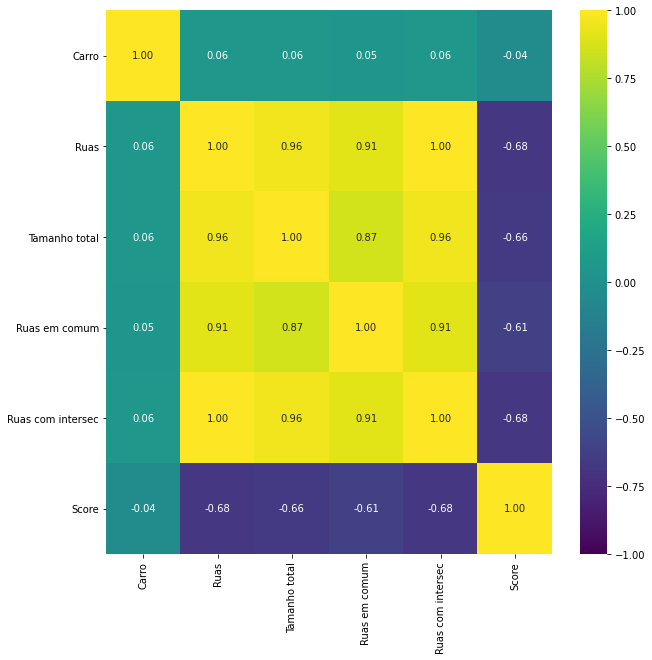

In [4]:
plt.figure(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1);

In [5]:
def data_sts(sts, cars, bkp_cars, inters):  
    data = []
    for st in sts:
        #print(sts[st])
        cars_with_st = 0
        score_st = 0
        for car in bkp_cars:
            if(st in set(bkp_cars[car])):
                cars_with_st += 1
                score_st += cars[car]['score']
        aux = sts[st]['size']
        tam_st = aux[2]
        coming = aux[0]
        going = aux[1]
        qtd_desembocam = len(inters[coming]['sts'])

        data.append([cars_with_st, tam_st, coming, going, qtd_desembocam, score_st])
    df_st = pd.DataFrame(data, columns=['Carros que passam por essa rua', 'Tamanho da Rua', 'Vem de', 'Vai para', 
            'Quantidade de ruas que desembocam nela', 'Score dos que passaram'])
    display(df_st.describe())
    return df_st
df_st = data_sts(sts, cars, bkp_cars, inters)

,Carros que passam por essa rua,Tamanho da Rua,Vem de,Vai para,Quantidade de ruas que desembocam nela,Score dos que passaram
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,1.781563,50.595190,311.374749,311.625251,63.374749,632.652305
std,1.675950,28.469034,165.300164,165.206086,107.658911,877.975773
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,26.000000,166.000000,166.250000,1.000000,0.000000
50%,1.000000,50.000000,332.000000,332.500000,1.000000,0.000000
75%,3.000000,75.000000,498.000000,498.750000,2.000000,1051.750000
max,10.000000,100.000000,499.000000,499.000000,250.000000,4980.000000


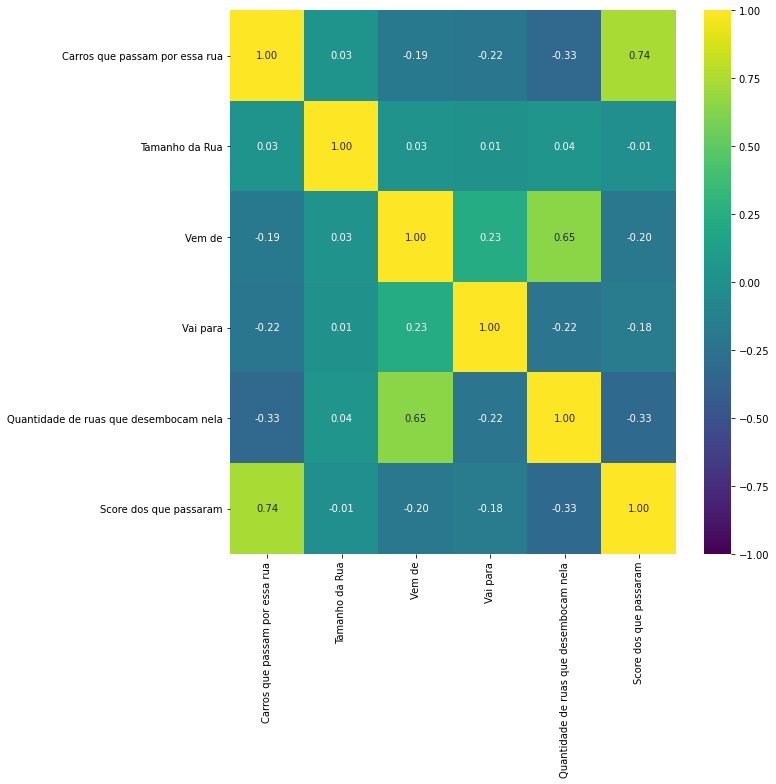

In [6]:
plt.figure(figsize=(10, 10))
corr = df_st.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis', vmin=-1, vmax=1);
#print(bkp_cars)

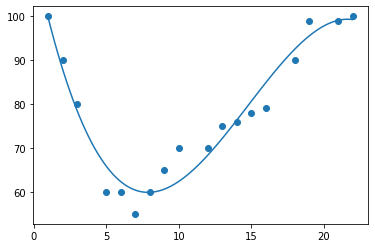

In [7]:
import numpy
from sklearn.metrics import r2_score

x = [1,2,3,5,6,7,8,9,10,12,13,14,15,16,18,19,21,22]
y = [100,90,80,60,60,55,60,65,70,70,75,76,78,79,90,99,99,100]

mymodel = numpy.poly1d(numpy.polyfit(x, y, 3))

speed = mymodel(17)

myline = numpy.linspace(1, 22, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()

#print(speed) 

In [8]:
def transform_schedule(schedule, score_t): 
    new_schedule = {}
    for _, value in schedule.items():
        progs = value['prog'].copy()
        for prog in progs:
            st_name = prog['st']
            t = prog['t']
            #prog['score'] = score
            new_schedule[st_name] = {'t': t, 'score': score_t}
    return new_schedule
#transform_schedule(schedule, total)

In [9]:
#dic = {}
import json

def get_dataset(name, deviation=1/2, n_samples=1, max_time=3, old_schedule=None):
    X, y = [], []
    schedules = []
    for t in range(0, n_samples):
        cars, bkp_cars, finished_cars, total, sts, inters, schedule, total, new_old_schedule = score_geral(name,
                                                                                        deviation=deviation,
                                                                                         max_time=max_time, 
                                                                                        old_schedule=old_schedule)
        
        schedules.append( new_old_schedule.copy() )
        schedule = transform_schedule(schedule, total)
        #print(schedule)
        row_in = []
        row_out = 0
        for _, value in schedule.items():
            row_in.append(value['t'])
            row_out = value['score']
            
        X.append(row_in)
        y.append(row_out)
        
        print(f'{t} foi')
    
    #st_schedules = [json.dumps(schedule) for schedule in schedules]
    #st_schedules = pd.DataFrame(data=st_schedules, columns=['schedule'])
    #print('st_schedules = ', st_schedules)
    known_schedules = set()
    not_duplicate_schedules = []
    for schedule in schedules.copy():
        st_schedule = str(schedule)
        if st_schedule not in known_schedules:
            known_schedules.add(st_schedule)
            not_duplicate_schedules.append( schedule.copy() )
    #import pdb; pdb.set_trace()
            
        
    X = pd.DataFrame(X)
    y = pd.DataFrame(data=y, columns=['score'])
    
    # Proximo episodio: juntar X com y e tirar duplicatas
    z = pd.concat([X, y], axis=1)
    z.drop_duplicates(inplace=True)
    #print(z.shape)
    
    n_cols = z.shape[1]
    col_names = [i for i in range(n_cols)]
    z.set_axis(col_names, axis=1)

    #st_schedules = z[['schedule']]
    y = z[['score']]
    X = z.drop(columns=['score'])
    
    #import ast
    #schedules = []
    #l = list(st_schedules['schedule'])
    #print('list schdules: ', l)
    #print('tam: ', len(l))
    #for st_schedule in l:
    #    print('item da lista')
    #    schedule = {}#json.dumps(json.dumps(st_schedule, indent=4), indent=4)
    #    print('schedule reconstruido: ', schedule)
    #    schedules.append(schedule)
    #print('schedules = ', schedules)
    
    return X, y, not_duplicate_schedules

X, y, not_duplicate_schedules = get_dataset('a', n_samples=1000)#[2]#.describe()
#X.shape, y.shape, len(not_duplicate_schedules), not_duplicate_schedules
#z[['score']]
#X.describe(), y.describe()

0 foi
1 foi
2 foi
3 foi
4 foi
5 foi
6 foi
7 foi
8 foi
9 foi
10 foi
11 foi
12 foi
13 foi
14 foi
15 foi
16 foi
17 foi
18 foi
19 foi
20 foi
21 foi
22 foi
23 foi
24 foi
25 foi
26 foi
27 foi
28 foi
29 foi
30 foi
31 foi
32 foi
33 foi
34 foi
35 foi
36 foi
37 foi
38 foi
39 foi
40 foi
41 foi
42 foi
43 foi
44 foi
45 foi
46 foi
47 foi
48 foi
49 foi
50 foi
51 foi
52 foi
53 foi
54 foi
55 foi
56 foi
57 foi
58 foi
59 foi
60 foi
61 foi
62 foi
63 foi
64 foi
65 foi
66 foi
67 foi
68 foi
69 foi
70 foi
71 foi
72 foi
73 foi
74 foi
75 foi
76 foi
77 foi
78 foi
79 foi
80 foi
81 foi
82 foi
83 foi
84 foi
85 foi
86 foi
87 foi
88 foi
89 foi
90 foi
91 foi
92 foi
93 foi
94 foi
95 foi
96 foi
97 foi
98 foi
99 foi
100 foi
101 foi
102 foi
103 foi
104 foi
105 foi
106 foi
107 foi
108 foi
109 foi
110 foi
111 foi
112 foi
113 foi
114 foi
115 foi
116 foi
117 foi
118 foi
119 foi
120 foi
121 foi
122 foi
123 foi
124 foi
125 foi
126 foi
127 foi
128 foi
129 foi
130 foi
131 foi
132 foi
133 foi
134 foi
135 foi
136 foi
137 foi
138 fo

In [10]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
linhas = 2
variaveis = 2
X = np.arange(linhas * variaveis).reshape(linhas, variaveis)

y = [[1, 3], [2,1]]
deg = 3

poly = PolynomialFeatures(deg)
print(poly.fit_transform(X, y), '\n')



poly = PolynomialFeatures(deg, interaction_only=False)
print(poly.fit_transform(X))


[[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]] 

[[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]


In [11]:
print(poly.powers_)

[[0 0]
 [1 0]
 [0 1]
 [2 0]
 [1 1]
 [0 2]
 [3 0]
 [2 1]
 [1 2]
 [0 3]]


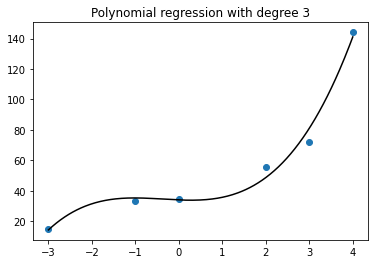

In [12]:
import pandas as pd
#xdic={'X': {11: 300, 12: 170, 13: 99, 14: }} 
#ydic={'y': {11: 305000, 12: 270000}}

def pol(x):
    x = x + random.random()
    return (x*x*x + 3*x + 34 )

xdic = [-3, -1, 0, 4, 3, 2]#, [-3, -1, 0, 4, 3, 2]]
ydic = [pol(el)for el in xdic] #,  [pol(el)for el in xdic[1]]]
X = pd.DataFrame.from_dict(xdic)
y = pd.DataFrame.from_dict(ydic)

import numpy as np4
X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1,1)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
#from sklearn.svm import SVC

degree = 3
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X,y)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X,y)
plt.plot(X_seq,polyreg.predict(X_seq),color="black")
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

In [13]:
# example of a multi-output regression problem
#from sklearn.datasets import make_regression
# create dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
# summarize shape
#print(X.shape, y.shape)

In [14]:
pd.DataFrame(X).head()

,0
0,-3
1,-1
2,0
3,4
4,3


In [15]:
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [16]:
model = Sequential()
model.add(Dense(20, input_dim=10, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# get the dataset
#def get_dataset():
	#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
	
#    return X, y

In [18]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model

In [19]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    print('corno')
    print(X.shape)
    print(y.shape)
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    #for train_ix, test_ix in cv.split(X):
    #    print('SO VOU PASSAR  UMA VEZ')
        # prepare data
    #    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]#X[train_ix], X[test_ix]
    #    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        # define model
    model = get_model(n_inputs, n_outputs)
        
        # fit model
    model.fit(X, y, verbose=0, epochs=100)
        
        # evaluate model on test set
    #    mae = model.evaluate(X_test, y_test, verbose=0)
        
        # store result
    #    print('>%.1f' % mae)
    #    results.append(mae)
        
    #import pdb; pdb.set_trace()
    return results

In [20]:
def find_max_score_random(name, deviation=1/2, n_samples=5, max_time=3, old_schedule=None): 
    # load dataset
    #import pdb; pdb.set_trace()
    X, y, old_schedules = get_dataset(name, deviation=deviation, n_samples=n_samples, max_time=max_time, old_schedule=old_schedule)

    # evaluate model
    #results = evaluate_model(X, y)
    #import pdb; pdb.set_trace()
    best_index = int(y.idxmax()) # indice do melhor score
    best_schedule = old_schedules[best_index]
    best_score = y['score'].iloc[best_index]

    # summarize performance
    #print('MAE: max: %.1f;  media: %.1f +/- (%.1f)' % (max(results), mean(results), std(results)))
    return best_schedule, best_score
    
    

In [23]:
import time
import json
from json import JSONDecodeError

max_sec = 30 #segundos
start = time.time()
end = time.time()
old_schedule = None
max_time = 2
deviation = 0.5

name = 'b'
hist_file_name = f'out/{name}_history.json'
print('Filename: ', hist_file_name)

try:
    with open(hist_file_name, 'r') as f:
        hist_list = json.load( f )
        if len(hist_list) <= 0:
            hist_list = []   
except FileNotFoundError as fnf:
    open(hist_file_name, 'w').write('[]')
except JSONDecodeError as jde:
    hist_list = []
    
    
def convert_int64(o):
    if isinstance(o, numpy.int64): return int(o)  
    raise TypeError

while end - start <= max_sec:
    
    hist_file_w = open(hist_file_name, 'w')
    old_schedule, old_score = find_max_score_random(name, deviation=deviation, n_samples=5, max_time=max_time, old_schedule=old_schedule)
    hist_dic = { 'schedule': old_schedule, 'score': old_score }
    hist_list.append( hist_dic )
    
    #import pdb; pdb.set_trace()
    hist_json = json.dumps( hist_list, indent=4, default=convert_int64 )
    hist_file_w.write( hist_json )
    
    #json.dump( hist_file_w )
    print('OI')
    
    end = time.time()
    #import pdb; pdb.set_trace()

Filename:  out/b_history.json
0 foi
1 foi
2 foi
3 foi
4 foi
OI
